In [1]:
#load data
import os
import numpy as np
import h5py
from pathlib import Path
from sklearn.utils import shuffle

#visualization
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import pprint

# deep learning library
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import load_model

# test model performance
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import numpy as np
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow import keras

# limit gpu memory
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


## 1.1. Directory set up

In [2]:
raw_data_path = Path('./data/mit-bih-arrhythmia-database-1.0.0')
# main directory that store data
data_dir = Path('./data')
os.makedirs(data_dir, exist_ok=True)

# directory that store original MIT-BIH data

mit_arrh_dir = raw_data_path
os.makedirs(mit_arrh_dir, exist_ok=True)

# directory that store processed data
process_dir = data_dir / 'processed_data'
temp_dir = process_dir / 'temp'
os.makedirs(process_dir, exist_ok=True)

raw_data_dir = process_dir
os.makedirs(raw_data_dir, exist_ok=True)



## Use this for interpatient
mit_processed_dir = process_dir / 'ECG_MIT-BIH_processed_data_interpatient_125Hz.h5'

## Use this for intrapatient
mit_processed_dir = process_dir / 'ECG_MIT-BIH_processed_data_intrapatient_125Hz.h5'

# directory that store models data
model_dir = Path("./model")
os.makedirs(model_dir, exist_ok=True)

## 1.2 Load train and test dataset
- Train and test set is splited and stratified with ratio of 4:1
- Dataformat: Each entry contain 1000 sample of of ECG data zero padded representing 2 consecutive heart beat starting from the peak of the first one
- Label: 5 classes (F, N, Q, S, V)


In [6]:
## read data from hdf5 file
with h5py.File(mit_processed_dir, 'r') as file:
    data_train = file.get('train_data')[:]
    label_train = file.get('train_labels')[:]
    data_test = file.get('test_data')[:]
    label_test_no_encoding = file.get('test_labels')[:]

## shuffle data
data_train, label_train = shuffle(data_train, label_train)

## resize data into array shape of (1000,1) to be fed into keras learning module
data_train = np.array(data_train)
# data_train = np.resize(data_train,(len(data_train), 1000, 1))

data_test = np.array(data_test)
# data_test = np.resize(data_test,(len(data_test), 1000, 1))

# Convert labels to categorical one-hot encoding for multiclass training
label_test = keras.utils.to_categorical(label_test_no_encoding, num_classes=5)
label_train = keras.utils.to_categorical(label_train, num_classes=5)

print("Train set length:", len(data_train), data_train.shape)
print("Test set length:", len(data_test), data_test.shape)

Train set length: 50999 (50999, 1024)
Test set length: 49690 (49690, 1024)


## 1.3 Visualize sample data

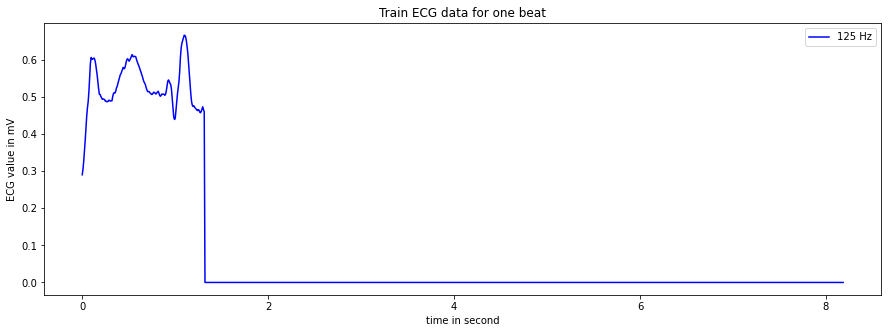

<Figure size 432x288 with 0 Axes>

In [7]:
## plot a sample train set signal
train_ecg_sample = data_train[1024]
train_time_in_second = np.arange(len(train_ecg_sample)) / 125.

plt.figure(figsize=(15,5))
plt.plot(train_time_in_second, train_ecg_sample, c='b', label='125 Hz')
plt.xlabel('time in second')
plt.ylabel('ECG value in mV')
plt.title('Train ECG data for one beat')
plt.legend()
plt.show()
plt.clf()

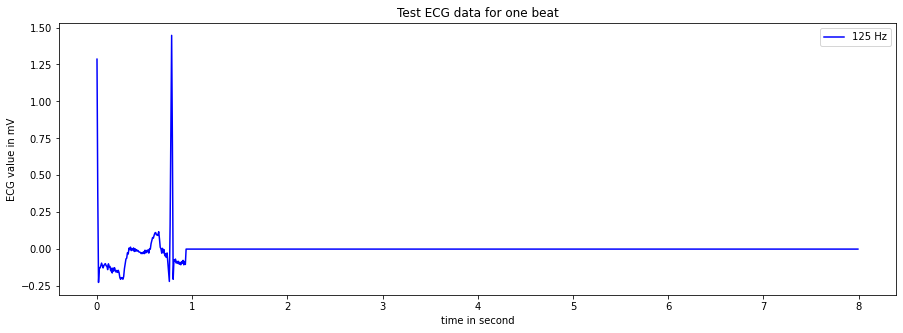

<Figure size 432x288 with 0 Axes>

In [7]:
## plot a sample test set signal
test_ecg_sample = data_test[1024]
test_time_in_second = np.arange(len(test_ecg_sample)) / 125.

plt.figure(figsize=(15,5))
plt.plot(test_time_in_second, test_ecg_sample, c='b', label='125 Hz')
plt.xlabel('time in second')
plt.ylabel('ECG value in mV')
plt.title('Test ECG data for one beat')
plt.legend()
plt.show()
plt.clf()

# 2 Classification

## 2.1 Define model

In [ ]:
def prepare_model(config, weight_path=None, suffix=''):
    input_shape = config['input_size']
    conv_filter_size = config['conv_filter_size']
    conv_filter_number = config['conv_filter_number']
    layer_num = config['layer_num']
    batch_norm = config['batch_norm']
    dropout_rate = config['dropout_rate']
    pooling_size = config['pooling_size']
    pooling_strides = config['pooling_strides']
    fc_filter_number = config['fc_filter_number']
    fc_layer_num = config['fc_layer_num']
    output_size = config['output_size']
    kernel_regularizer = config['kernel_regularizer']
    
    if weight_path is None:
        trainable = True
    else:
        trainable = False
        
    if kernel_regularizer is not None:
        kernel_regularizer = keras.regularizers.l2(kernel_regularizer)
    
    inputs = keras.Input(shape=input_shape)
    start_outputs = layers.Conv1D(conv_filter_number, conv_filter_size, padding='same', 
                                  kernel_regularizer=kernel_regularizer,
                                  name='start_conv', trainable=trainable)(inputs)
    
    prev_output = start_outputs
    for i in range(layer_num):
        conv1 = layers.Conv1D(conv_filter_number, conv_filter_size,
                              kernel_regularizer=kernel_regularizer,
                              padding='same', name='r{}_conv_{}'.format(i, 0), trainable=trainable)(prev_output)
        act1 = layers.Activation('relu')(conv1)

        if batch_norm:
            batch1 = layers.BatchNormalization(name='r{}_batch_{}'.format(i, 0), trainable=trainable)(act1)
        else:
            batch1 = conv1
            
        conv2 = layers.Conv1D(conv_filter_number, conv_filter_size, padding='same',
                              kernel_regularizer=kernel_regularizer,
                              name='r{}_conv_{}'.format(i, 1), trainable=trainable)(batch1)
        merge = layers.add([conv2, prev_output])
        act2 = layers.Activation('relu')(merge)
        
        if batch_norm:
            batch2 = layers.BatchNormalization(name='r{}_batch_{}'.format(i, 1), trainable=trainable)(act2)
        else:
            batch2 = act2
            
        prev_output = layers.MaxPooling1D(pool_size=pooling_size, strides=pooling_strides)(batch2)
        
    flatten = layers.Flatten()(prev_output)
    
    prev_output = flatten
    for i in range(fc_layer_num):
        pred_x0 = layers.Dense(fc_filter_number,
                               kernel_regularizer=kernel_regularizer,
                               name='{}pred_x_{}'.format(suffix, i))(prev_output)
        pred_a0 = layers.Activation('relu')(pred_x0)

        if batch_norm:
            pred_b0 = layers.BatchNormalization(name='{}p1_batch_{}'.format(suffix, i))(pred_a0)
        else:
            pred_b0 = pred_a0

        if dropout_rate is not None:
            pred_d0 = layers.Dropout(dropout_rate)(pred_b0)
        else:
            pred_d0 = pred_b0
        
        prev_output = pred_d0
    
    pred_outputs = layers.Dense(output_size, activation='softmax', name='output')(prev_output)
    
    full_model = keras.Model(inputs=inputs, outputs=pred_outputs, name='{}full_model'.format(suffix))
    
    if weight_path is not None:
        full_model.load_weights(weight_path, by_name=True)
    
    full_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])
    
    return full_model

model_config = {
    "input_size": (1024,1),
    "conv_filter_number": 32,
    "conv_filter_size":5,
    "batch_norm": True,
    "dropout_rate": 0.2,
    "layer_num": 5,
    "pooling_size": 5,
    "pooling_strides": 2,
    "fc_filter_number": 32,
    "fc_layer_num": 2,
    "output_size": 5,
    "kernel_regularizer": None
}

model_model = prepare_model(model_config, suffix='CNN')
print(model_model.summary())

## 2.2 Train model

In [9]:
## train model with 0.2 spit for validation
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import pandas as pd

def train_model(model, data_train, label_train, data_test, label_test, epochs, batch_size, suffix='', save_dir=None):
    """
    This function will train the model on the train dataset
    Validation split is set to 20%
    """
    if save_dir is not None:
        mc = ModelCheckpoint(str(save_dir / (suffix + '_model_{epoch:04d}.h5')),
                              save_freq='epoch')
        history = model.fit(data_train, label_train, validation_data=(data_test, label_test),
                            epochs=epochs, batch_size=batch_size, callbacks=[mc], shuffle=True)
        
    else:
        history = model.fit(data_train, label_train, validation_split=0.2, epochs=epochs, batch_size=batch_size)
    return history



def record_train_history(history, save_dir, name):
    plt.figure(figsize=(10,5))
    step = np.arange(1, len(history.history['loss']) + 1)
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model result')
    plt.xlabel('Epoch')
    plt.xticks(step)
    plt.legend(['Train', 'Test', 'Loss', 'Val_loss'], loc='upper left')
    plt.savefig(save_dir / '{}.png'.format(name))
    plt.clf()
    plt.close()

    d = {'epochs': step,
         'categorical_accuracy': history.history['categorical_accuracy'],
         'val_categorical_accuracy': history.history['val_categorical_accuracy'],
         'loss': history.history['loss'],
         'val_lost': history.history['val_loss']
        }
    df = pd.DataFrame(data=d)
    df.to_csv(save_dir / '{}.csv'.format(name), index=False)

In [10]:
model_dir = Path("./") / "model"
result_dir = Path("./") / "result"

os.makedirs(model_dir, exist_ok = True)
os.makedirs(result_dir, exist_ok = True)

model_config = {
    "input_size": (1024,1),
    "conv_filter_number": 32,
    "conv_filter_size":5,
    "batch_norm": True,
    "dropout_rate": 0.2,
    "layer_num": 5,
    "pooling_size": 5,
    "pooling_strides": 2,
    "fc_filter_number": 32,
    "fc_layer_num": 2,
    "output_size": 5,
    "kernel_regularizer": None
}

model_model = prepare_model(model_config, suffix='CNN')

history = train_model(model, data_train, label_train, data_test, label_test,
                              epochs, batch_size, suffix=exp_name, save_dir=model_dir)
record_train_history(history, result_dir, "CNN")

## 2.3 Test model

In [ ]:
## test model

def test_model(model, data_test, label_test):
    """
    This function will run test of the model on the test dataset and return 
        - classification report string (for display purpose)
        - dictionary of classification report (for query purpose)
        - confusion matrix
    """
    Y_pred = model.predict(data_test)
    y_pred = np.argmax(Y_pred, axis=1)
    class_labels = np.argmax(label_test, axis=1)
    target_names = ['N', 'S', 'V', 'F', 'Q']
    
    report = classification_report(class_labels, y_pred, target_names=target_names, digits=3)
    report_dict = classification_report(class_labels, y_pred, target_names=target_names, output_dict=True)
    c_matrix = confusion_matrix(class_labels, y_pred)
    return report, report_dict, c_matrix

test_config = {
    "input_size": (1000,1),
    "conv_filter_number": 32,
    "conv_filter_size":5,
    "batch_norm": True,
    "dropout_rate": 0.2,
    "layer_num": 5,
    "pooling_size": 5,
    "pooling_strides": 2,
    "fc_filter_number": 32,
    "fc_layer_num": 2,
    "output_size": 5,
    "kernel_regularizer": None
}

trained_model = keras.models.load_model(Path("./model/interpatient.h5"))

report, report_dict, c_matrix = test_model(trained_model, data_test, label_test)

In [17]:
## support is number of instance in a class
print('Dataset training result:\n', report)

Unbalanced dataset training result:
               precision    recall  f1-score   support

           N      0.944     0.845     0.892     44238
           S      0.000     0.000     0.000      1836
           V      0.309     0.924     0.464      3221
           F      0.010     0.013     0.012       388
           Q      0.000     0.000     0.000         7

    accuracy                          0.812     49690
   macro avg      0.253     0.356     0.273     49690
weighted avg      0.861     0.812     0.824     49690



Normalized confusion matrix


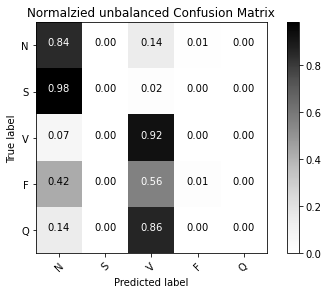

<Figure size 432x288 with 0 Axes>

In [18]:
import itertools

## display confusion matrix
display_labels = ['N', 'S', 'V', 'F', 'Q']

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    plt.clf()
    
plot_confusion_matrix(c_matrix, display_labels ,
                      title='Normalzied Confusion Matrix', normalize=True, cmap='Greys')